# Feature Selection Experiments for openSMILE

The [openSMILE Python API](https://audeering.github.io/opensmile-python/) includes the [ComParE 2016](http://www.tangsoo.de/documents/Publications/Schuller16-TI2.pdf) feature set which enables us to extract 65 low-level descriptors (for ex. MFCC) as well as 6373 Functionals derived from these decriptors. 

For each audio file - the LLDs are a `samples x 65` df and the functionals are a `1 x 6373` df. 

In these experiments, we extract the functionals for both real and fake audio data and run a set of feature selection techniques to identify a hnadful subset of features for use in a final predictive model.

## Import Statements

In [1]:
import opensmile 
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix
import random
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn import svm
from pprint import pprint
from tqdm import tqdm
base_path = "/home/ubuntu/"

## Data Loading and Summary

To save time, the data is sampled and features are extracted using openSMILE in a separate notebook `sampling_and_mixing_data.ipynb` and saved in `.csv` format for reusability. The dataset used contains original audio from the [LJSpeech 1.1](https://keithito.com/LJ-Speech-Dataset/) dataset and fake audio generated using GANs for the [NeurIPS 2021 WaveFake](https://arxiv.org/abs/2111.02813) dataset. It also contains audio from LJSpeech generated using ElevenLabs.

Contains 12,800 audio files - 6400 each real and fake with a set of 800 real audio files matching a set of the same 800 fakes generated using one of the archs listed below. 

In [2]:
exp_data_file = '/home/ubuntu/testing-code/opensmile-feature-importance/smile_dfs/0310-lj_experimental_data_v1.csv'
exp_data_df = pd.read_csv(exp_data_file)

In [3]:
exp_data_df.head()

,id,file,type,fake,duration(seconds),audspec_lengthL1norm_sma_range,audspec_lengthL1norm_sma_maxPos,audspec_lengthL1norm_sma_minPos,audspec_lengthL1norm_sma_quartile1,audspec_lengthL1norm_sma_quartile2,...,mfcc_sma_de[14]_peakRangeAbs,mfcc_sma_de[14]_peakRangeRel,mfcc_sma_de[14]_peakMeanAbs,mfcc_sma_de[14]_peakMeanMeanDist,mfcc_sma_de[14]_peakMeanRel,mfcc_sma_de[14]_minRangeRel,mfcc_sma_de[14]_meanRisingSlope,mfcc_sma_de[14]_stddevRisingSlope,mfcc_sma_de[14]_meanFallingSlope,mfcc_sma_de[14]_stddevFallingSlope
0,LJ032-0137,/home/ubuntu/data/wavefake_data/LJSpeech_1.1/w...,ElevenLabs,0,7.762,2.529597,0.608866,0.765319,0.343702,0.589645,...,10.773912,0.657822,2.936347,2.935397,20.000000,0.609994,129.240130,64.158455,130.97571,60.847908
1,LJ038-0165,/home/ubuntu/data/wavefake_data/LJSpeech_1.1/w...,ElevenLabs,0,8.656,2.406416,0.005841,0.695093,0.295922,0.514596,...,8.458103,0.531263,2.910538,2.911863,-20.000000,0.650057,125.028530,58.838596,115.42761,55.276188
2,LJ044-0203,/home/ubuntu/data/wavefake_data/LJSpeech_1.1/w...,ElevenLabs,0,5.150,2.695161,0.249012,0.175889,0.375376,0.674925,...,11.555664,0.663116,2.731076,2.731820,-20.000000,0.479881,126.260170,54.306473,109.07703,62.240750
3,LJ003-0044,/home/ubuntu/data/wavefake_data/LJSpeech_1.1/w...,ElevenLabs,0,3.199,2.287197,0.528846,0.996795,0.478625,0.801715,...,11.162925,0.497092,3.827386,3.820832,19.997963,0.526514,155.382830,77.223274,146.11166,88.627940
4,LJ036-0116,/home/ubuntu/data/wavefake_data/LJSpeech_1.1/w...,ElevenLabs,0,2.340,2.027513,0.181416,0.513274,0.277241,0.572403,...,6.160469,0.462080,2.797420,2.774368,19.579084,0.638266,99.164055,44.689617,123.44574,49.456890


In [4]:
exp_data_df.shape

(12800, 6378)

In [5]:
exp_data_df.type.value_counts()

ElevenLabs           1600
Waveglow             1600
Parallel_WaveGan     1600
Multi_Band_MelGan    1600
MelGanLarge          1600
MelGan               1600
HifiGan              1600
Full_Band_MelGan     1600
Name: type, dtype: int64

In [6]:
#check to ensure each id has a corresponding fake
exp_data_df.id.value_counts()

LJ032-0137    2
LJ038-0118    2
LJ046-0168    2
LJ016-0171    2
LJ037-0020    2
             ..
LJ004-0171    2
LJ042-0184    2
LJ015-0150    2
LJ007-0172    2
LJ028-0069    2
Name: id, Length: 6400, dtype: int64

## Train-Dev-Test Split:

In [7]:
#split the data 
f1 = 0.8
f2 = 0.9
train_df, dev_df, test_df = np.split(exp_data_df.sample(frac=1), [int(f1*len(exp_data_df)), int(f2*len(exp_data_df))])

In [8]:
#check split
len(train_df), len(dev_df), len(test_df), (len(train_df) + len(dev_df) + len(test_df))

(10240, 1280, 1280, 12800)

In [9]:
train_df.type.value_counts()

Full_Band_MelGan     1303
Waveglow             1299
HifiGan              1284
MelGan               1281
Multi_Band_MelGan    1273
Parallel_WaveGan     1272
ElevenLabs           1268
MelGanLarge          1260
Name: type, dtype: int64

In [10]:
dev_df.type.value_counts()

ElevenLabs           177
HifiGan              164
Parallel_WaveGan     163
Multi_Band_MelGan    163
MelGanLarge          159
MelGan               159
Full_Band_MelGan     148
Waveglow             147
Name: type, dtype: int64

In [11]:
test_df.type.value_counts()

MelGanLarge          181
Parallel_WaveGan     165
Multi_Band_MelGan    164
MelGan               160
ElevenLabs           155
Waveglow             154
HifiGan              152
Full_Band_MelGan     149
Name: type, dtype: int64

## Feature Scaling:

In [12]:
exp_data_scaler = StandardScaler()
train_df.iloc[:,5:] = exp_data_scaler.fit_transform(train_df.iloc[:,5:])
dev_df.iloc[:,5:] = exp_data_scaler.transform(dev_df.iloc[:,5:])
test_df.iloc[:,5:] = exp_data_scaler.transform(test_df.iloc[:,5:])

## Experiment 1: Brute Force Feature Selection

In the first experiment, we break down the data set into each architecture used to generate fakes 

In [13]:
def run_bflr_for_arch(train_df, dev_df, arch, all_archs=False):
    
    #prepare data
    if all_archs==False:
        trdf = train_df[train_df.type==arch]
    if all_archs==True:
        trdf = train_df[train_df.type.isin(arch)]
    
    if all_archs==False:
        dvdf = dev_df[dev_df.type==arch]
    if all_archs==True:
        dvdf = dev_df[dev_df.type.isin(arch)]
    
    X_train = trdf.drop(columns=['id', 'file', 'type', 'duration(seconds)', 'fake']).copy()
    y_train = trdf['fake'].copy()
    
    X_dev = dvdf.drop(columns=['id', 'file', 'type', 'duration(seconds)', 'fake'])
    y_dev = dvdf['fake'].copy()
    
    train_accuracies = []
    dev_accuracies = []
    
    for i in tqdm(range(6373)):
        
        model_lr = LogisticRegression()
        model_lr.fit(X_train.iloc[:,i].to_numpy().reshape(-1, 1), y_train)
        y_hat_train = model_lr.predict(X_train.iloc[:,i].to_numpy().reshape(-1, 1))
        y_hat_dev = model_lr.predict(X_dev.iloc[:,i].to_numpy().reshape(-1, 1))
        train_accuracy = accuracy_score(y_train, y_hat_train)
        train_accuracies.append(train_accuracy)        
        dev_accuracy = accuracy_score(y_dev, y_hat_dev)
        dev_accuracies.append(dev_accuracy)
    
    print("\nAverage train accuracy: {}".format(np.mean(train_accuracies)))
    print("Average dev accuracy: {}\n".format(np.mean(dev_accuracies)))
    
    return dev_accuracies

In [14]:
archs = list(exp_data_df.type.unique())
features = train_df.columns.to_list()[5:]
bruteforce_df = pd.DataFrame(features, columns=['features'])

for arch in archs:
    print("\nRunning for {} architecture\n".format(arch))
    bruteforce_df[arch] = run_bflr_for_arch(train_df, dev_df, arch)

print("\nRunning for all architectures\n")
bruteforce_df['all_archs'] = run_bflr_for_arch(train_df, dev_df, archs, all_archs=True)


Running for ElevenLabs architecture



100%|██████████| 6373/6373 [00:13<00:00, 488.52it/s]



Average train accuracy: 0.6238718548925598
Average dev accuracy: 0.6145559346856131


Running for Waveglow architecture



100%|██████████| 6373/6373 [00:11<00:00, 540.48it/s]



Average train accuracy: 0.5289866180299949
Average dev accuracy: 0.5084588362255306


Running for Parallel_WaveGan architecture



100%|██████████| 6373/6373 [00:11<00:00, 543.01it/s]



Average train accuracy: 0.5280699728710055
Average dev accuracy: 0.5281117906351469


Running for Multi_Band_MelGan architecture



100%|██████████| 6373/6373 [00:11<00:00, 543.51it/s]



Average train accuracy: 0.5251856041832017
Average dev accuracy: 0.5215282263460015


Running for MelGanLarge architecture



100%|██████████| 6373/6373 [00:11<00:00, 542.03it/s]



Average train accuracy: 0.530086749904732
Average dev accuracy: 0.5183789315577609


Running for MelGan architecture



100%|██████████| 6373/6373 [00:11<00:00, 541.53it/s]



Average train accuracy: 0.5233798226392496
Average dev accuracy: 0.5103221432399065


Running for HifiGan architecture



100%|██████████| 6373/6373 [00:11<00:00, 543.40it/s]



Average train accuracy: 0.5176613956953326
Average dev accuracy: 0.5063558916618509


Running for Full_Band_MelGan architecture



100%|██████████| 6373/6373 [00:11<00:00, 544.83it/s]



Average train accuracy: 0.5164111498299799
Average dev accuracy: 0.5036482033579162


Running for all architectures



100%|██████████| 6373/6373 [00:26<00:00, 243.32it/s]


Average train accuracy: 0.5174817559185235
Average dev accuracy: 0.5174327975443276



In [15]:
bruteforce_df[(bruteforce_df.iloc[:,1:] > 0.55).all(1)]

,features,ElevenLabs,Waveglow,Parallel_WaveGan,Multi_Band_MelGan,MelGanLarge,MelGan,HifiGan,Full_Band_MelGan,all_archs
1250,pcm_fftMag_spectralFlux_sma_percentile99.0,0.683616,0.551020,0.754601,0.619632,0.628931,0.616352,0.628049,0.594595,0.579688
1251,pcm_fftMag_spectralFlux_sma_pctlrange0-1,0.683616,0.551020,0.766871,0.619632,0.628931,0.622642,0.621951,0.594595,0.578125
2945,pcm_fftMag_spectralFlux_sma_de_range,0.762712,0.598639,0.699387,0.607362,0.578616,0.584906,0.615854,0.581081,0.553906
2954,pcm_fftMag_spectralFlux_sma_de_percentile1.0,0.717514,0.591837,0.711656,0.564417,0.603774,0.635220,0.640244,0.608108,0.577344
2955,pcm_fftMag_spectralFlux_sma_de_percentile99.0,0.830508,0.605442,0.668712,0.595092,0.597484,0.572327,0.634146,0.608108,0.564063
2956,pcm_fftMag_spectralFlux_sma_de_pctlrange0-1,0.813559,0.625850,0.705521,0.588957,0.610063,0.654088,0.646341,0.641892,0.585156
2957,pcm_fftMag_spectralFlux_sma_de_stddev,0.836158,0.639456,0.693252,0.601227,0.572327,0.647799,0.628049,0.594595,0.566406
2970,pcm_fftMag_spectralFlux_sma_de_lpgain,0.881356,0.591837,0.687117,0.650307,0.603774,0.559748,0.597561,0.554054,0.550781
3737,jitterLocal_sma_flatness,0.700565,0.653061,0.576687,0.736196,0.603774,0.698113,0.652439,0.587838,0.600000
3776,jitterDDP_sma_flatness,0.661017,0.714286,0.705521,0.779141,0.672956,0.704403,0.713415,0.668919,0.674219


In [16]:
bruteforce_df[(bruteforce_df.iloc[:,1:] > 0.6).all(1)]

,features,ElevenLabs,Waveglow,Parallel_WaveGan,Multi_Band_MelGan,MelGanLarge,MelGan,HifiGan,Full_Band_MelGan,all_archs
3776,jitterDDP_sma_flatness,0.661017,0.714286,0.705521,0.779141,0.672956,0.704403,0.713415,0.668919,0.674219


In [17]:
bruteforce_df[(bruteforce_df.iloc[:,2:-1] > 0.55).all(axis=1)]

,features,ElevenLabs,Waveglow,Parallel_WaveGan,Multi_Band_MelGan,MelGanLarge,MelGan,HifiGan,Full_Band_MelGan,all_archs
350,audSpec_Rfilt_sma[3]_percentile1.0,0.502825,0.551020,0.570552,0.576687,0.566038,0.553459,0.615854,0.574324,0.513281
1250,pcm_fftMag_spectralFlux_sma_percentile99.0,0.683616,0.551020,0.754601,0.619632,0.628931,0.616352,0.628049,0.594595,0.579688
1251,pcm_fftMag_spectralFlux_sma_pctlrange0-1,0.683616,0.551020,0.766871,0.619632,0.628931,0.622642,0.621951,0.594595,0.578125
1265,pcm_fftMag_spectralFlux_sma_lpgain,0.926554,0.585034,0.656442,0.650307,0.578616,0.559748,0.585366,0.574324,0.458594
2945,pcm_fftMag_spectralFlux_sma_de_range,0.762712,0.598639,0.699387,0.607362,0.578616,0.584906,0.615854,0.581081,0.553906
2954,pcm_fftMag_spectralFlux_sma_de_percentile1.0,0.717514,0.591837,0.711656,0.564417,0.603774,0.635220,0.640244,0.608108,0.577344
2955,pcm_fftMag_spectralFlux_sma_de_percentile99.0,0.830508,0.605442,0.668712,0.595092,0.597484,0.572327,0.634146,0.608108,0.564063
2956,pcm_fftMag_spectralFlux_sma_de_pctlrange0-1,0.813559,0.625850,0.705521,0.588957,0.610063,0.654088,0.646341,0.641892,0.585156
2957,pcm_fftMag_spectralFlux_sma_de_stddev,0.836158,0.639456,0.693252,0.601227,0.572327,0.647799,0.628049,0.594595,0.566406
2970,pcm_fftMag_spectralFlux_sma_de_lpgain,0.881356,0.591837,0.687117,0.650307,0.603774,0.559748,0.597561,0.554054,0.550781


In [18]:
bruteforce_df[(bruteforce_df.iloc[:,2:-1] > 0.9).any(axis=1)]

,features,ElevenLabs,Waveglow,Parallel_WaveGan,Multi_Band_MelGan,MelGanLarge,MelGan,HifiGan,Full_Band_MelGan,all_archs
1701,mfcc_sma[6]_lpc1,0.740113,0.598639,0.558282,0.533742,0.943396,0.899371,0.615854,0.608108,0.647656
1732,mfcc_sma[7]_lpc1,0.830508,0.448980,0.404908,0.527607,0.911950,0.886792,0.524390,0.574324,0.631250
1762,mfcc_sma[8]_lpc0,0.796610,0.585034,0.521472,0.490798,0.918239,0.861635,0.536585,0.527027,0.613281
1763,mfcc_sma[8]_lpc1,0.598870,0.455782,0.503067,0.582822,0.943396,0.874214,0.609756,0.540541,0.620313
1794,mfcc_sma[9]_lpc1,0.576271,0.469388,0.460123,0.533742,0.924528,0.874214,0.609756,0.527027,0.585156
1825,mfcc_sma[10]_lpc1,0.683616,0.462585,0.478528,0.533742,0.880503,0.905660,0.548780,0.560811,0.601562
1885,mfcc_sma[12]_lpgain,0.785311,0.605442,0.687117,0.680982,0.937107,0.817610,0.560976,0.500000,0.594531
1886,mfcc_sma[12]_lpc0,0.734463,0.551020,0.582822,0.564417,0.918239,0.899371,0.536585,0.493243,0.576562
1916,mfcc_sma[13]_lpgain,0.598870,0.571429,0.644172,0.650307,0.924528,0.842767,0.481707,0.574324,0.585156
1947,mfcc_sma[14]_lpgain,0.711864,0.666667,0.656442,0.601227,0.911950,0.830189,0.585366,0.506757,0.588281


In [19]:
bruteforce_df[(bruteforce_df.iloc[:,-1] > 0.60)]

,features,ElevenLabs,Waveglow,Parallel_WaveGan,Multi_Band_MelGan,MelGanLarge,MelGan,HifiGan,Full_Band_MelGan,all_archs
66,pcm_RMSenergy_sma_quartile2,0.666667,0.619048,0.693252,0.656442,0.490566,0.591195,0.591463,0.567568,0.616406
67,pcm_RMSenergy_sma_quartile3,0.666667,0.585034,0.705521,0.711656,0.553459,0.503145,0.609756,0.601351,0.617188
68,pcm_RMSenergy_sma_iqr1-2,0.661017,0.571429,0.631902,0.705521,0.459119,0.547170,0.634146,0.601351,0.605469
1088,pcm_fftMag_fband1000-4000_sma_quartile1,0.762712,0.687075,0.705521,0.582822,0.622642,0.540881,0.469512,0.520270,0.617188
1436,pcm_fftMag_spectralSlope_sma_percentile99.0,0.977401,0.564626,0.736196,0.552147,0.641509,0.515723,0.591463,0.601351,0.603906
1575,mfcc_sma[2]_lpgain,0.779661,0.734694,0.601227,0.515337,0.610063,0.672956,0.542683,0.540541,0.616406
1576,mfcc_sma[2]_lpc0,0.757062,0.605442,0.533742,0.533742,0.679245,0.641509,0.554878,0.547297,0.601562
1577,mfcc_sma[2]_lpc1,0.593220,0.619048,0.527607,0.558282,0.723270,0.723270,0.554878,0.581081,0.606250
1608,mfcc_sma[3]_lpc1,0.536723,0.551020,0.601227,0.539877,0.805031,0.849057,0.542683,0.520270,0.607031
1668,mfcc_sma[5]_lpgain,0.700565,0.612245,0.619632,0.552147,0.685535,0.704403,0.420732,0.540541,0.603906


In [20]:
max_idxs = []
for arch in archs + ['all_archs']:
    max_idxs.append(bruteforce_df[arch].idxmax())
bruteforce_df[bruteforce_df.index.isin(max_idxs)]

,features,ElevenLabs,Waveglow,Parallel_WaveGan,Multi_Band_MelGan,MelGanLarge,MelGan,HifiGan,Full_Band_MelGan,all_archs
93,pcm_zcr_sma_range,1.000000,0.537415,0.576687,0.503067,0.572327,0.496855,0.548780,0.567568,0.564063
1701,mfcc_sma[6]_lpc1,0.740113,0.598639,0.558282,0.533742,0.943396,0.899371,0.615854,0.608108,0.647656
3468,mfcc_sma_de[8]_lpc1,0.655367,0.448980,0.546012,0.533742,0.918239,0.918239,0.591463,0.574324,0.614062
3790,jitterDDP_sma_quartile1,0.451977,0.863946,0.797546,0.920245,0.559748,0.849057,0.774390,0.641892,0.720313
3796,jitterDDP_sma_percentile1.0,0.519774,0.836735,0.699387,0.895706,0.616352,0.823899,0.774390,0.716216,0.722656


In [21]:
feats_lr_1 = bruteforce_df[(bruteforce_df.iloc[:,1:] > 0.55).all(1)].features.to_list()
feats_lr_2 = bruteforce_df[(bruteforce_df.iloc[:,1:] > 0.6).all(1)].features.to_list()
feats_lr_3 = bruteforce_df[(bruteforce_df.iloc[:,2:-1] > 0.55).all(axis=1)].features.to_list()
feats_lr_4 = bruteforce_df[(bruteforce_df.iloc[:,2:-1] > 0.9).any(axis=1)].features.to_list()
feats_lr_5 = bruteforce_df[(bruteforce_df.iloc[:,-1] > 0.60)].features.to_list()
feats_lr_6 = bruteforce_df[bruteforce_df.index.isin(max_idxs)].features.to_list()

exp_1_feature_set = set().union(feats_lr_1, feats_lr_2, feats_lr_3, feats_lr_4, feats_lr_5, feats_lr_6)

In [22]:
selected_features = list(exp_1_feature_set)

In [23]:
exp_1_feature_set

{'audSpec_Rfilt_sma[3]_percentile1.0',
 'jitterDDP_sma_flatness',
 'jitterDDP_sma_iqr1-2',
 'jitterDDP_sma_percentile1.0',
 'jitterDDP_sma_quartile1',
 'jitterDDP_sma_quartile2',
 'jitterLocal_sma_flatness',
 'jitterLocal_sma_percentile1.0',
 'jitterLocal_sma_quartile1',
 'jitterLocal_sma_quartile2',
 'mfcc_sma[10]_lpc0',
 'mfcc_sma[10]_lpc1',
 'mfcc_sma[12]_lpc0',
 'mfcc_sma[12]_lpgain',
 'mfcc_sma[13]_lpgain',
 'mfcc_sma[14]_lpgain',
 'mfcc_sma[2]_lpc0',
 'mfcc_sma[2]_lpc1',
 'mfcc_sma[2]_lpgain',
 'mfcc_sma[3]_lpc1',
 'mfcc_sma[5]_lpc0',
 'mfcc_sma[5]_lpc1',
 'mfcc_sma[5]_lpgain',
 'mfcc_sma[6]_lpc0',
 'mfcc_sma[6]_lpc1',
 'mfcc_sma[6]_lpgain',
 'mfcc_sma[7]_lpc0',
 'mfcc_sma[7]_lpc1',
 'mfcc_sma[7]_lpgain',
 'mfcc_sma[8]_lpc0',
 'mfcc_sma[8]_lpc1',
 'mfcc_sma[9]_lpc0',
 'mfcc_sma[9]_lpc1',
 'mfcc_sma[9]_lpgain',
 'mfcc_sma_de[10]_lpc0',
 'mfcc_sma_de[10]_lpc1',
 'mfcc_sma_de[11]_lpgain',
 'mfcc_sma_de[12]_lpc1',
 'mfcc_sma_de[12]_lpgain',
 'mfcc_sma_de[13]_lpc1',
 'mfcc_sma_de[13]_

In [24]:
len(exp_1_feature_set)

94

#### Test on held out test data

In [25]:
df_lr_final = pd.concat([train_df, dev_df])
X_train_lr_final = df_lr_final.drop(columns=['id', 'file', 'type', 'duration(seconds)', 'fake']).copy()
y_train_lr_final = df_lr_final['fake'].copy()

X_test_lr_final = test_df.drop(columns=['id', 'file', 'type', 'duration(seconds)', 'fake']).copy()
y_test_lr_final = test_df['fake'].copy()

In [26]:
#select features identified from brute force
feature_index = train_df.columns.intersection(selected_features)

#fit model
model_lr_final = LogisticRegression(max_iter=1000)
model_lr_final.fit(X_train_lr_final[feature_index], y_train_lr_final)

#predict on held out test data
yhat_train_final = model_lr_final.predict(X_train_lr_final[feature_index])
yhat_test_final = model_lr_final.predict(X_test_lr_final[feature_index])

#compute accuracy
accuracy_lr_train = accuracy_score(y_train_lr_final, yhat_train_final)
accuracy_lr_test = accuracy_score(y_test_lr_final, yhat_test_final)

#print
print('Logistic accuracy train = %.3f' % (accuracy_lr_train*100))
print('Logistic accuracy test = %.3f' % (accuracy_lr_test*100))

Logistic accuracy train = 93.108
Logistic accuracy test = 93.359


## SQS testing

In [27]:
X_train = train_df.drop(columns=['id', 'file', 'type', 'duration(seconds)', 'fake']).copy()
y_train = train_df['fake'].copy()

X_dev = dev_df.drop(columns=['id', 'file', 'type', 'duration(seconds)', 'fake'])
y_dev = dev_df['fake'].copy()

X_test = test_df.drop(columns=['id', 'file', 'type', 'duration(seconds)', 'fake'])
y_test = test_df['fake'].copy()

In [28]:
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import RFECV

In [29]:
cv = StratifiedKFold(5)
visualizer = RFECV(LogisticRegression(max_iter=1000), step=50, cv=cv, scoring='f1_weighted')

KeyboardInterrupt: 

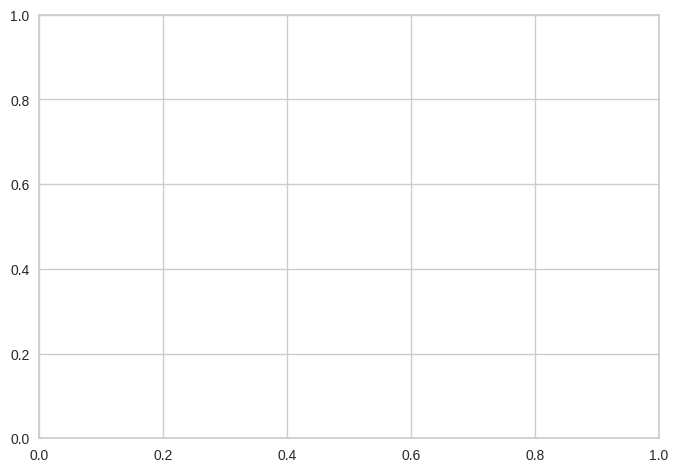

In [30]:
visualizer.fit(X_train, y_train)
visualizer.show()